# A Feedforward Neural Network for Financial Time Series Forecasting 

Author: Moritz Ahl 

Date: January 2022

Software: Windows 10, Python 3.9, Jupyter Notebook 6.4.5

- This notebook provides an easy expample of a feedforward neural network (FFNN) to predict the close price of the DAX index using TensorFlow and the interface Keras. 
- The data will be downloaded using Yahoo!Finance.
- This program is inspired by https://github.com/bnsreenu/python_for_microscopists/blob/master/164a-Intro_to_time_series_Forecasting_using_feed_forward_NN.py.

### Please always restart the kernel before running!

In [1]:
#Load standard packages 
import numpy as np
import matplotlib.pyplot as plt
import time
import math

#Load model and layer for NNs from TensorFlow using the Keras interface 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

#Load useful functions from scikit-learn 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#Load Yahoo!Finance for download of market data
import yfinance as yf


In [2]:
#Download daily data of S&P500 index for a given period using Yahoo!Finance
start = '2005-1-1'
end = '2021-10-1'
df = yf.download(tickers='^GSPC', start=start, end=end, interval='1d') #^GDAXI

#Print data frame
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-12-31,1213.550049,1217.329956,1211.650024,1211.920044,1211.920044,786900000
2005-01-03,1211.920044,1217.800049,1200.319946,1202.079956,1202.079956,1510800000
2005-01-04,1202.079956,1205.839966,1185.390015,1188.050049,1188.050049,1721000000
2005-01-05,1188.050049,1192.729980,1183.719971,1183.739990,1183.739990,1738900000
2005-01-06,1183.739990,1191.630005,1183.270020,1187.890015,1187.890015,1569100000
...,...,...,...,...,...,...
2021-09-24,4438.040039,4463.120117,4430.270020,4455.479980,4455.479980,2772090000
2021-09-27,4442.120117,4457.299805,4436.189941,4443.109863,4443.109863,3032870000
2021-09-28,4419.540039,4419.540039,4346.330078,4352.629883,4352.629883,3495970000


It is often helpful to scale the data to improve the performance of the neural network and allow a better handling of the model. 
Reference?!

The next step is to split the data into a training and a test set. Here, the first $80\%$ of the observations will serve as the training data. 

The test data ranges from train_size-seq_size onwards to allow for a prediction of the first day in test set!

In [3]:
def rolling_windows(data, seq_size=1):
    ''' Function to create rolling windows of observations which will be used
        as input data for the neural network. seq_size is the amount of days
        we look back into the past to use previous closing prices. Data should 
        be a dataframe downloaded with Yahoo!Finance.'''
    #Create empty lists to store data 
    x = []
    y = []
    
    #Create rolling windows (input) of last seq_size observations
    #and list with current observatiosn (output)
    for i in range(len(data)-seq_size):
        window = data[i:(i+seq_size),0]
        x.append(window)
        y.append(data[i+seq_size,0])
        
    return np.array(x), np.array(y)

In [4]:
def preparations(df, seq_size=1, perc=0.8, plot=True, scale=True):
    '''Function to create training and test datasets. df is a dataframe 
       of financial market data downloaded with Yahoo!Finance, seq_size 
       gives the number of past days` closing price we take as the input 
       for the NN, perc gives the percentage of the data that should be 
       used as training data, plot allows for a plot of the close prices 
       and scale allows for the scaling of the data into a [0,1]-frame'''
    
    #Extract the close prices and reshape them into 2d-array
    data = np.array(df['Close'].values)
    data = data.reshape((len(data),1))
    data = data.astype('float32')

    #Extract dates and reshape them
    dates = np.array(df.index)
    dates = dates.reshape((len(dates),1))

    #Plot close prices for given period
    if plot:
        plt.plot(dates,data)
        plt.title('Close prices for S&P500 index from {} to {}'.format(start,end))
        plt.show()
        
    #Compute log returns
    z = np.array([0])
    z = z.reshape((1,1))
    ret = np.concatenate((z,np.log(data[1:]/data[:-1])))
    data = abs(ret)
    data = data.reshape((len(data),1))
    data = data.astype('float32')
    
    #Plot log returns for given period
    if plot:
        plt.plot(dates,data)
        plt.title('Log returns for S&P500 index from {} to {}'.format(start,end))
        plt.show()
        
    #Scale data into [0,1] using a preimplemented function from scikit-learn
    if scale:
        scaler = MinMaxScaler(feature_range=(0,1))
        data = scaler.fit_transform(data)  
    else:
        scaler = []
    
    #CHECK FOR NANS!!
    #Verify if first date has an entry
    if np.isnan(data[0,0]):
        print('NaN for starting date. Please change date.')
        
    else:
        #Test for NaNs and fill forward if NaNs exist
        for i in range(len(data)):
            if np.isnan(data[i,0]):
                data[i,0] = data[i-1,0]
                
        #seq_size is the amount of observations of close prices from previous days that 
        #will serve as the input for the neural network

        #Determine length of training data and split data 
        train_size = int(len(data)*perc)
        test_size = len(data) - train_size
        train, test = data[0:train_size,:], data[(train_size-seq_size):len(data),:] 

        #The test data ranges from train_size-seq_size onwards 
        #to allow for a prediction of the first day in test set.
        
        #Create rolling windows for input and output data
        trainX, trainY = rolling_windows(train, seq_size)
        testX, testY = rolling_windows(test, seq_size)
        
    return data, dates, trainX, trainY, testX, testY, scaler


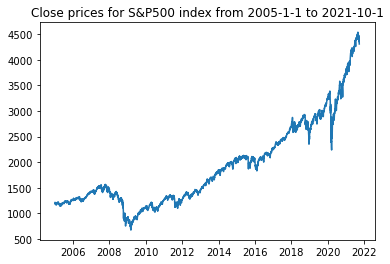

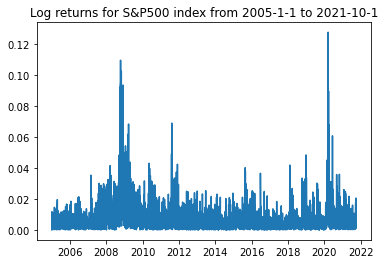

In [5]:
#Apply preparations function to get training and test data sets
seq_size = 10
perc = 0.8
data, dates, trainX, trainY, testX, testY, scaler = preparations(df, seq_size=seq_size, perc=perc, plot=True, scale=True)

In [6]:
#Print shapes of both, the training data and the test data
print('Shape of training set: {}'.format(trainX.shape))
print('Shape of test set: {}'.format(testX.shape))

Shape of training set: (3363, 10)
Shape of test set: (844, 10)


After the preparation of the data has been completed, the next step is to create the NN we want to use for the predictions. In this example, a simple feedforward neural network (FFNN) with an input $x \in \mathbb{R}^{seq\_size}$ and thus $seq\_size$ neurons in this layers will be used. Two hidden layers will be created with $64$ and $32$ neurons respectively, resulting in a n output layer with a single neuron. A $ReLU$ function will be chosen for the activation function:

$$ReLU(x) := max \lbrace 0,x \rbrace, \quad x \in \mathbb{R}^n, n \in \mathbb{N}.$$

Furthermore, the loss funcion will be the mean squared error (MSE) and the optimizer a classical of ADAM type.  

In [7]:
#Create FFNN model using Keras and print details 
model = Sequential()
model.add(Dense(64,input_dim=seq_size, activation = 'relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1)) #output layer
model.compile(loss='mean_squared_error',optimizer='adam')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None


Continue by fitting the parameters of the model.

In [8]:
#Use the implemented fitting function to get the model
# model checkpointing -> save only best model  
mc = ModelCheckpoint('model_FTS.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#epochs: number of evaluations of function value
start_time = time.time()
model.fit(trainX, trainY, validation_split=0.2, epochs=200, callbacks=[mc]) 
end_time = time.time()

#Store the fitted model weights to memory
model.save_weights('Saved Models/FFNN_FTS')

Epoch 1/200
77/85 [==========================>...] - ETA: 0s - loss: 0.0046
Epoch 00001: val_loss improved from inf to 0.00188, saving model to model_FTS.h5
85/85 [==============================] - 3s 10ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 2/200
73/85 [========================>.....] - ETA: 0s - loss: 0.0043
Epoch 00002: val_loss did not improve from 0.00188
85/85 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 3/200
79/85 [==========================>...] - ETA: 0s - loss: 0.0040
Epoch 00003: val_loss did not improve from 0.00188
85/85 [==============================] - 1s 7ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 4/200
84/85 [============================>.] - ETA: 0s - loss: 0.0040
Epoch 00004: val_loss improved from 0.00188 to 0.00186, saving model to model_FTS.h5
85/85 [==============================] - 0s 5ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 5/200
74/85 [=========================>....] - ETA: 0s - loss: 0.0039
Epo

Epoch 39/200
74/85 [=========================>....] - ETA: 0s - loss: 0.0027
Epoch 00039: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 40/200
82/85 [===========================>..] - ETA: 0s - loss: 0.0026
Epoch 00040: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 41/200
83/85 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 00041: val_loss did not improve from 0.00180
85/85 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 42/200
84/85 [============================>.] - ETA: 0s - loss: 0.0027
Epoch 00042: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 43/200
82/85 [===========================>..] - ETA: 0s - loss: 0.0031
Epoch 00043: val_loss did not improve from 0.00180
85/85 [=====

Epoch 77/200
80/85 [===========================>..] - ETA: 0s - loss: 0.0021
Epoch 00077: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 78/200
84/85 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 00078: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 79/200
76/85 [=========================>....] - ETA: 0s - loss: 0.0021
Epoch 00079: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 80/200
71/85 [========================>.....] - ETA: 0s - loss: 0.0021
Epoch 00080: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 81/200
83/85 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 00081: val_loss did not improve from 0.00180
85/85 [=====

Epoch 115/200
85/85 [==============================] - ETA: 0s - loss: 0.0020
Epoch 00115: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 116/200
79/85 [==========================>...] - ETA: 0s - loss: 0.0020
Epoch 00116: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 5ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 117/200
75/85 [=========================>....] - ETA: 0s - loss: 0.0019
Epoch 00117: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 118/200
77/85 [==========================>...] - ETA: 0s - loss: 0.0018
Epoch 00118: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 119/200
83/85 [============================>.] - ETA: 0s - loss: 0.0019
Epoch 00119: val_loss did not improve from 0.00180
85/85 [

Epoch 153/200
78/85 [==========================>...] - ETA: 0s - loss: 0.0017
Epoch 00153: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 154/200
76/85 [=========================>....] - ETA: 0s - loss: 0.0018
Epoch 00154: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 155/200
83/85 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 00155: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 5ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 156/200
62/85 [====================>.........] - ETA: 0s - loss: 0.0036
Epoch 00156: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 157/200
78/85 [==========================>...] - ETA: 0s - loss: 0.0020
Epoch 00157: val_loss did not improve from 0.00180
85/85 [

Epoch 191/200
70/85 [=======================>......] - ETA: 0s - loss: 0.0016
Epoch 00191: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 192/200
82/85 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 00192: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 193/200
82/85 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 00193: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 194/200
80/85 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 00194: val_loss did not improve from 0.00180
85/85 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 195/200
70/85 [=======================>......] - ETA: 0s - loss: 0.0021
Epoch 00195: val_loss did not improve from 0.00180
85/85 [

In [9]:
# load best model
from tensorflow.keras.models import load_model
model = load_model('model_FTS.h5')

In [10]:
print('The training of the model parameters took %.2f seconds.' % (end_time-start_time))

The training of the model parameters took 99.26 seconds.


The fitted model should be evaluated. Here, two possiblities are presented:
- use of evaluation function in Keras
- computation of mean squared error

Furthermore, a plot of the absolute error will be given at the end of the program.


In [11]:
#Evaluate model with training dataset and test datset
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#trainPredict.shape
loss = model.evaluate(testX, testY)
print('\nThe evaluation of the fitted model hints a loss function value of {:e}.'.format(loss))

27/27 [==============================] - 0s 4ms/step - loss: 0.0053

The evaluation of the fitted model hints a loss function value of 5.272862e-03.


In [12]:
#Inverse the scaling to get real values
trainPredict = scaler.inverse_transform(trainPredict)  #inverse of standardization
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

In [13]:
#Manual evaluation of the model using root of MSE
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0],trainPredict[:,0]))
print('Train Score: %.3e RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY_inverse[0],testPredict[:,0]))
print('Test Score: %.3e RMSE' % (testScore))

#_, accuracy = model.evaluate(test_roll,test_close)
#print('Accuracy: %.2f' % (accuracy*100))

Train Score: 7.175e-03 RMSE
Test Score: 9.269e-03 RMSE


To conclude, a plot of the observed data and the predictions of the model and the absolute error will be shown.

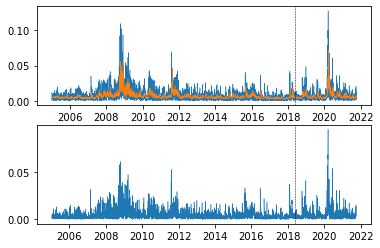

In [14]:
#Create one array that contains both training and test predictions
predictions = np.empty([len(data),1])
predictions[:,:] = np.nan
predictions[seq_size:len(trainPredict)+seq_size,:] = trainPredict
predictions[(len(trainPredict)+(seq_size)):,:] = testPredict

#Compute absolute error of predictions
error = abs((scaler.inverse_transform(data[seq_size:]) - predictions[seq_size:]))#/scaler.inverse_transform(data[seq_size:])

#Plot and save figure of observations vs. predictions and the error
fig, axs = plt.subplots(2,1)
axs[0].plot(dates,scaler.inverse_transform(data),label='data',lw=.5)
axs[0].plot(dates,predictions,label='predictions',lw=.5)
#Add vertical dashed line to mark end of training set
axs[0].axvline(x=dates[len(trainPredict)+seq_size],color='k', linestyle='--',lw=0.5)
axs[1].plot(dates[seq_size:],error,label='error',lw=.5)
axs[1].axvline(x=dates[len(trainPredict)+seq_size],color='k', linestyle='--',lw=0.5)

plt.savefig('C:/Users/morit/Documents/Studium/Master-Arbeit 2021/Master Thesis TeX/figures/FFN1.pdf')
plt.show()